# L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 372.32794189453125
iteration 0 loss 338.52117919921875


iteration 5000 loss 0.4644588828086853


iteration 10000 loss 0.3842998445034027


iteration 15000 loss 0.33135896921157837


iteration 20000 loss 0.3034732937812805


iteration 25000 loss 0.26591551303863525


iteration 30000 loss 0.23387929797172546


iteration 35000 loss 0.20316511392593384


iteration 40000 loss 0.14703895151615143


iteration 45000 loss 0.06500691920518875


iteration 50000 loss 0.02795802615582943


iteration 55000 loss 0.01940661109983921


iteration 60000 loss 0.01445050910115242


iteration 65000 loss 0.012761031277477741


iteration 70000 loss 0.011336534284055233


iteration 75000 loss 0.009574909694492817


iteration 80000 loss 0.008833063766360283


iteration 85000 loss 0.008088893257081509


iteration 90000 loss 0.007993707433342934


iteration 95000 loss 0.007295016199350357


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.007358136586844921


iteration 105000 loss 0.00669492781162262


iteration 110000 loss 0.0061393906362354755


iteration 115000 loss 0.005789297167211771


iteration 120000 loss 0.005475206766277552


iteration 125000 loss 0.00519138015806675


iteration 130000 loss 0.004975493997335434


iteration 135000 loss 0.004746359772980213


iteration 140000 loss 0.0045663476921617985


iteration 145000 loss 0.004394835326820612


iteration 150000 loss 0.004243557807058096


iteration 155000 loss 0.004119708202779293


iteration 160000 loss 0.003991404082626104


iteration 165000 loss 0.0038808181416243315


iteration 170000 loss 0.003775783348828554


iteration 175000 loss 0.0037073371931910515


iteration 180000 loss 0.00356382061727345


iteration 185000 loss 0.0034740050323307514


iteration 190000 loss 0.003395566949620843


iteration 195000 loss 0.0033256507012993097


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.02598106674849987


iteration 205000 loss 0.0032344055362045765


iteration 210000 loss 0.0031571383588016033


iteration 215000 loss 0.0030809487216174603


iteration 220000 loss 0.0030038715340197086


iteration 225000 loss 0.0029245775658637285


iteration 230000 loss 0.0028641268145292997


iteration 235000 loss 0.002790299942716956


iteration 240000 loss 0.00273348530754447


iteration 245000 loss 0.0026857280172407627


iteration 250000 loss 0.0026394049637019634


iteration 255000 loss 0.0025931259151548147


iteration 260000 loss 0.002547474578022957


iteration 265000 loss 0.0024984071496874094


iteration 270000 loss 0.0024591193068772554


iteration 275000 loss 0.0024233509320765734


iteration 280000 loss 0.002388658933341503


iteration 285000 loss 0.0023543089628219604


iteration 290000 loss 0.0023195904213935137


iteration 295000 loss 0.0022845061030238867


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0022503319196403027


iteration 305000 loss 0.0022269508335739374


iteration 310000 loss 0.0021852736826986074


iteration 315000 loss 0.002145773731172085


iteration 320000 loss 0.002108190208673477


iteration 325000 loss 0.0020722541958093643


iteration 330000 loss 0.002037813188508153


iteration 335000 loss 0.0020048285368829966


iteration 340000 loss 0.0019732220098376274


iteration 345000 loss 0.0019427415682002902


iteration 350000 loss 0.001913216314278543


iteration 355000 loss 0.0018845538143068552


iteration 360000 loss 0.001856754650361836


iteration 365000 loss 0.0018297279020771384


iteration 370000 loss 0.0018034263048321009


iteration 375000 loss 0.0017778357723727822


iteration 380000 loss 0.0017529526958242059


iteration 385000 loss 0.0017287229420617223


iteration 390000 loss 0.0017051679315045476


iteration 395000 loss 0.0016822319012135267


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0016599292866885662


iteration 405000 loss 0.0016565135447308421


iteration 410000 loss 0.0016524966340512037


iteration 415000 loss 0.0016485955566167831


iteration 420000 loss 0.0016447709640488029


iteration 425000 loss 0.0016410067910328507


iteration 430000 loss 0.001637295470573008


iteration 435000 loss 0.0016336299013346434


iteration 440000 loss 0.001630004495382309


iteration 445000 loss 0.0016264138976112008


iteration 450000 loss 0.0016228561289608479


iteration 455000 loss 0.0016193261835724115


iteration 460000 loss 0.001615826040506363


iteration 465000 loss 0.0016123573295772076


iteration 470000 loss 0.001608914928510785


iteration 475000 loss 0.0016054948791861534


iteration 480000 loss 0.0016020942712202668


iteration 485000 loss 0.0015987154329195619


iteration 490000 loss 0.0015953555703163147


iteration 495000 loss 0.0015920151490718126


L2 loss -- Plot

loss -133.93930053710938


loss -246.71551513671875


loss -335.960205078125


loss -419.78607177734375


loss -495.6465148925781


loss -556.3409423828125


loss -595.1464233398438


loss -616.2083129882812


loss -627.952880859375


loss -635.096923828125


loss -639.8382568359375


loss -643.358154296875


loss -646.219482421875


loss -648.661865234375


loss -650.793212890625


loss -652.6727905273438


loss -654.3383178710938


loss -655.8123168945312


loss -657.110107421875


loss -658.246337890625


loss -659.2366943359375


loss -660.0972900390625


loss -660.8430786132812


loss -661.4863891601562


loss -662.0383911132812


loss -662.51025390625


loss -662.9127807617188


loss -663.2548828125


loss -663.5430908203125


loss -663.781494140625


loss -663.97265625


loss -664.118896484375


loss -664.2239990234375


loss -664.2940063476562


loss -664.3368530273438


loss -664.360595703125


loss -664.3726196289062


loss -664.3779907226562


loss -664.3800048828125


loss -664.380615234375


final mse:  1.2239629310073497e-09
max, min: 13.6887 -13.193163
loss -133.93930053710938


loss -245.1143035888672


loss -333.38629150390625


loss -417.2803649902344


loss -493.4781494140625


loss -548.0816650390625


loss -579.9677124023438


loss -602.859375


loss -619.5933837890625


loss -630.4226684570312


loss -636.7318725585938


loss -640.270263671875


loss -642.2532348632812


loss -643.3623046875


loss -643.96923828125


loss -644.2880859375


loss -644.4459228515625


loss -644.5181884765625


loss -644.5482177734375


loss -644.5590209960938


loss -644.562255859375


loss -644.56298828125


loss -644.5631103515625


loss -644.5631103515625


loss -644.5631103515625


loss -644.5631713867188


loss -644.5631103515625


loss -644.5631103515625


loss -644.5631103515625


loss -644.5631713867188


loss -644.5631103515625


loss -644.5631103515625


loss -644.5631713867188


loss -644.5631713867188


loss -644.5631713867188


loss -644.5631103515625


loss -644.5631713867188


loss -644.5631713867188


loss -644.5631103515625


loss -644.5631713867188


final mse:  1.724456827334464e-10
max, min: 5.431842 -5.993642


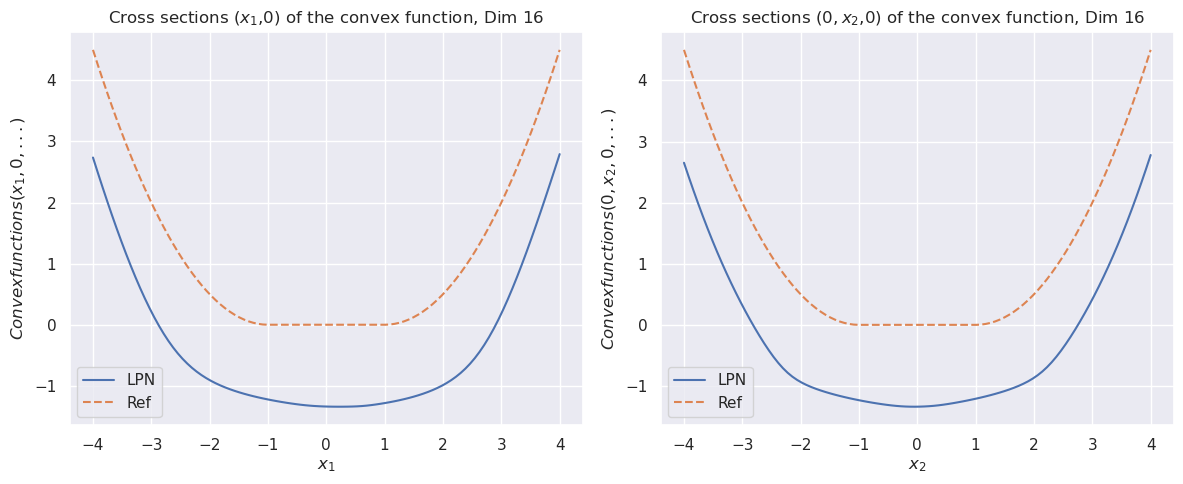

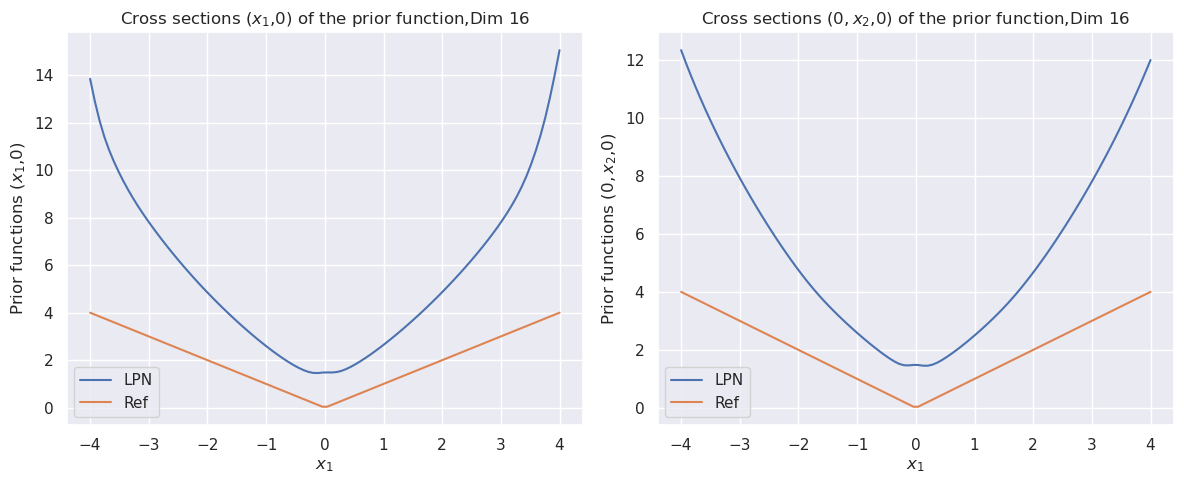

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1289.3421630859375
iteration 0 loss 103.126708984375


iteration 5000 loss 0.3332690894603729


iteration 10000 loss 0.0351446233689785


iteration 15000 loss 0.023966418579220772


iteration 20000 loss 0.01955091580748558


iteration 25000 loss 0.05631627142429352


iteration 30000 loss 0.4691939949989319


iteration 35000 loss 0.01132289133965969


iteration 40000 loss 0.010149821639060974


iteration 45000 loss 0.00909390114247799


iteration 50000 loss 0.007753998972475529


iteration 55000 loss 0.007437456864863634


iteration 60000 loss 0.006801696494221687


iteration 65000 loss 0.0061887456104159355


iteration 70000 loss 0.08955458551645279


iteration 75000 loss 0.005407470744103193


iteration 80000 loss 0.005008180160075426


iteration 85000 loss 0.004439444746822119


iteration 90000 loss 0.004014570731669664


iteration 95000 loss 0.003767113434150815


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0035433960147202015


iteration 105000 loss 0.003210595576092601


iteration 110000 loss 0.0035579605028033257


iteration 115000 loss 0.0027209636755287647


iteration 120000 loss 0.002547867363318801


iteration 125000 loss 0.002405828796327114


iteration 130000 loss 0.002271598670631647


iteration 135000 loss 0.002143919002264738


iteration 140000 loss 0.0020399722270667553


iteration 145000 loss 0.0019381671445444226


iteration 150000 loss 0.0018479065038263798


iteration 155000 loss 0.001765977474860847


iteration 160000 loss 0.001683332258835435


iteration 165000 loss 0.00161098747048527


iteration 170000 loss 0.0015429991763085127


iteration 175000 loss 0.0014839324867352843


iteration 180000 loss 0.0014263833872973919


iteration 185000 loss 0.0013711232459172606


iteration 190000 loss 0.0013198007363826036


iteration 195000 loss 0.001269811182282865


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0012224536621943116


iteration 205000 loss 0.0012018998386338353


iteration 210000 loss 0.001156102167442441


iteration 215000 loss 0.0011156188556924462


iteration 220000 loss 0.0010770292719826102


iteration 225000 loss 0.0010397647274658084


iteration 230000 loss 0.0010051607387140393


iteration 235000 loss 0.0009666988044045866


iteration 240000 loss 0.0009373364155180752


iteration 245000 loss 0.0009051439119502902


iteration 250000 loss 0.0008792723529040813


iteration 255000 loss 0.0008486555889248848


iteration 260000 loss 0.0008235755958594382


iteration 265000 loss 0.0007969134603627026


iteration 270000 loss 0.0007723431335762143


iteration 275000 loss 0.0007495802128687501


iteration 280000 loss 0.0007263337029144168


iteration 285000 loss 0.0007065857644192874


iteration 290000 loss 0.0006866492331027985


iteration 295000 loss 0.0006670262082479894


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0006472380482591689


iteration 305000 loss 0.0006371802883222699


iteration 310000 loss 0.0006122849299572408


iteration 315000 loss 0.0005894298665225506


iteration 320000 loss 0.0005681136972270906


iteration 325000 loss 0.0005477788508869708


iteration 330000 loss 0.0005292974528856575


iteration 335000 loss 0.0005120677524246275


iteration 340000 loss 0.0004957289202138782


iteration 345000 loss 0.000479642185382545


iteration 350000 loss 0.00046412067604251206


iteration 355000 loss 0.0004491957661230117


iteration 360000 loss 0.0004347601789049804


iteration 365000 loss 0.0004212952044326812


iteration 370000 loss 0.0004086732224095613


iteration 375000 loss 0.00039717392064630985


iteration 380000 loss 0.0003856429539155215


iteration 385000 loss 0.00037468638038262725


iteration 390000 loss 0.00036457227542996407


iteration 395000 loss 0.00035450997529551387


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0003448550123721361


iteration 405000 loss 0.0003417047264520079


iteration 410000 loss 0.0003365404554642737


iteration 415000 loss 0.00033156436984427273


iteration 420000 loss 0.00032671980443410575


iteration 425000 loss 0.0003219858917873353


iteration 430000 loss 0.0003173519507981837


iteration 435000 loss 0.0003128056996501982


iteration 440000 loss 0.00030834367498755455


iteration 445000 loss 0.0003039625007659197


iteration 450000 loss 0.0002996489347424358


iteration 455000 loss 0.00029540390823967755


iteration 460000 loss 0.00029122360865585506


iteration 465000 loss 0.0002871102187782526


iteration 470000 loss 0.00028305721934884787


iteration 475000 loss 0.0002790646394714713


iteration 480000 loss 0.00027513140230439603


iteration 485000 loss 0.00027125311316922307


iteration 490000 loss 0.00026743323542177677


iteration 495000 loss 0.0002636664139572531


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


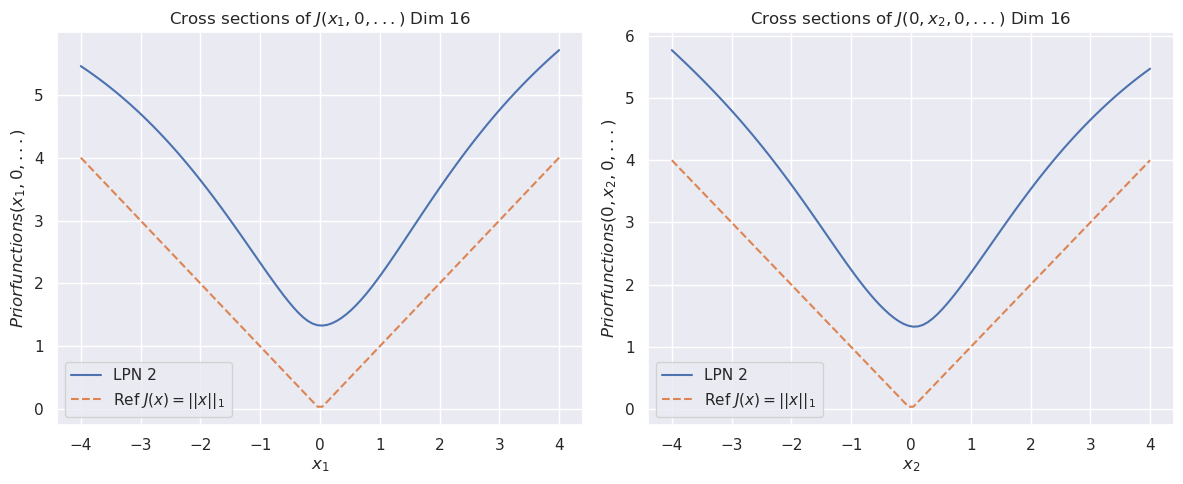

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)